# SQLite Basics
In this project we'll be looking at a CIA factbook, a dataset of geographic and social variables for each country in the world used as a reference tool by CIA agents.

Our goal in this project is to try out some of the basic syntax of SQLite in Python. We'll be loading up the database, then write queries to examine and elaborate the data.

In [8]:
import sqlite3 # sqlite3 is the library we use to operate with SQLite in a Python environment
import pandas as pd

In [9]:
conn = sqlite3.connect("factbook.db") # This produces a connection object - we'll be using this to run queries and commands

In [10]:
# Let's see what tables are present in the database
query1 = "SELECT * FROM sqlite_master WHERE type='table';"
info = pd.read_sql_query(query1,conn)
print(info)

    type             name         tbl_name  rootpage  \
0  table  sqlite_sequence  sqlite_sequence         3   
1  table            facts            facts        47   

                                                 sql  
0             CREATE TABLE sqlite_sequence(name,seq)  
1  CREATE TABLE "facts" ("id" INTEGER PRIMARY KEY...  


In [11]:
# Let's also look at the first 5 entries directly and see what's what
query2 = "SELECT * FROM facts LIMIT 5;"
five_facts = pd.read_sql_query(query2,conn)
print(five_facts)

   id code         name     area  area_land  area_water  population  \
0   1   af  Afghanistan   652230     652230           0    32564342   
1   2   al      Albania    28748      27398        1350     3029278   
2   3   ag      Algeria  2381741    2381741           0    39542166   
3   4   an      Andorra      468        468           0       85580   
4   5   ao       Angola  1246700    1246700           0    19625353   

   population_growth  birth_rate  death_rate  migration_rate  
0               2.32       38.57       13.89            1.51  
1               0.30       12.92        6.58            3.30  
2               1.84       23.67        4.31            0.92  
3               0.12        8.13        6.96            0.00  
4               2.78       38.78       11.49            0.46  


As we've seen, the sqlite3 library lets us work with SQLite just as we would normally in its native environment. The difference is that instead of directly writing queries and commands into an SQLite prompt we store these as string variables and pass them into a connection object using dedicated functions.

Apart from that, the SQL syntax is unchanged - for example, let's find out the country with the least and most inhabitants.

In [12]:
# Least inhabitants
query3 = "SELECT name, MIN(population) FROM facts;"
min_pop = pd.read_sql_query(query3,conn)
min_pop

,name,MIN(population)
0,Antarctica,0


In [13]:
# Most inhabitants
query4 = "SELECT name, MAX(population) FROM facts;"
max_pop = pd.read_sql_query(query4,conn)
max_pop

,name,MAX(population)
0,World,7256490011


Apparently the factbook contains entries for supranational entities as well as one for Antarctica itself! 

Let's continue and find the country with the least and most population growth too.

In [14]:
# Least population growth
query5 = "SELECT name, MIN(population_growth) FROM facts;"
min_pop_growth = pd.read_sql_query(query5,conn)
min_pop_growth

,name,MIN(population_growth)
0,Holy See (Vatican City),0.0


In [15]:
# Most population growth
query6 = "SELECT name, MAX(population_growth) FROM facts;"
max_pop_growth = pd.read_sql_query(query6,conn)
max_pop_growth

,name,MAX(population_growth)
0,South Sudan,4.02


### Data manipulation and visualization

We can now further elaborate the data and use the matplotlib.pyplot library to visualize some of the data we're working with. But first of all, let's say we want to operate with "proper" countries only, and that we want to get rid of the Antarctica and World entries. 

There's multiple way to do this: for example, we can single them out by name.

In [21]:
# A new DataFrame containing data from all countries which are neither Antarctica nor the whole World
query7 = "SELECT * FROM facts WHERE name != 'Antarctica' AND name != 'World';"
pop_facts = pd.read_sql_query(query7,conn)

In [22]:
# Import the matplotlib.pyplot library
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5,0,'Death rate')

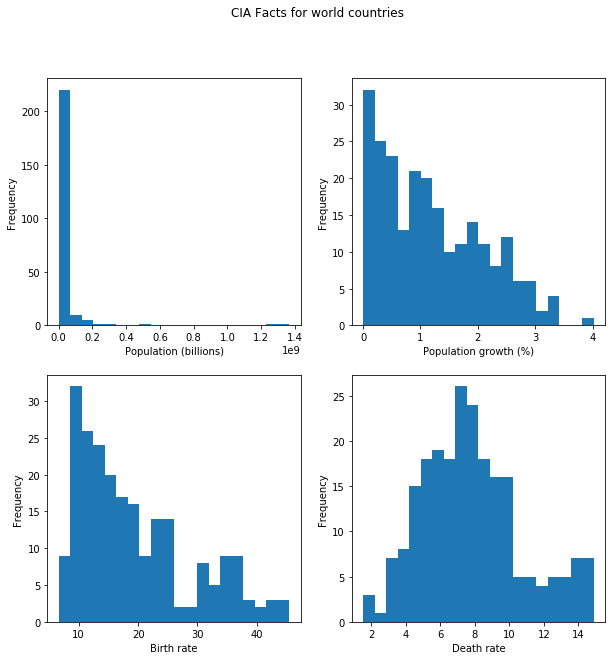

In [24]:
# Let's take a look at histograms of the population, population_growth, birth_rate and death_rate columns
fig, axes = plt.subplots(2,2,figsize=(10,10))
fig.suptitle("CIA Facts for world countries", fontsize = 12)
pop_facts["population"].plot.hist(bins=20, ax = axes[0,0])
axes[0,0].set_xlabel("Population (billions)")
pop_facts["population_growth"].plot.hist(bins=20, ax = axes[0,1])
axes[0,1].set_xlabel("Population growth (%)")
pop_facts["birth_rate"].plot.hist(bins=20, ax = axes[1,0])
axes[1,0].set_xlabel("Birth rate")
pop_facts["death_rate"].plot.hist(bins=20, ax = axes[1,1])
axes[1,1].set_xlabel("Death rate")

Let's say we're interested in the average population density of each country. There's no column for it at the moment, but we can make one as the ratio between total population and total land area.

In [26]:
pop_facts["pop_density"] = pop_facts["population"]/pop_facts["area_land"]

In [30]:
pop_density_top_10 = pop_facts.sort_values("pop_density", ascending=False).head(10)
pop_density_top_10.loc[:,["name","population","area_land","pop_density"]]

,name,population,area_land,pop_density
189,Holy See (Vatican City),842.0,0.0,inf
204,Macau,592731.0,28.0,2.116896e+04
116,Monaco,30535.0,2.0,1.526750e+04
155,Singapore,5674472.0,687.0,8.259785e+03
203,Hong Kong,7141106.0,1073.0,6.655271e+03
249,Gaza Strip,1869055.0,360.0,5.191819e+03
232,Gibraltar,29258.0,6.0,4.876333e+03
12,Bahrain,1346613.0,760.0,1.771859e+03
107,Maldives,393253.0,298.0,1.319641e+03
109,Malta,413965.0,316.0,1.310016e+03


Vatican City has infinite average population density! A quick glance at the area_land column tells us this is of course because we're dividing by zero. The land area data is given as an integer, and a quick [web search](https://en.wikipedia.org/wiki/Vatican_City) shows that Vatican City has a land area of 0.44 squared kilometers, which was rounded down to zero!

Let's remove the Vatican City entry from our database.

In [31]:
pop_facts = pop_facts[pop_facts["area_land"] > 0]

In [32]:
# Plot out the top 10 countries by population density again
pop_density_top_10 = pop_facts.sort_values("pop_density", ascending=False).head(10)
pop_density_top_10.loc[:,["name","population","area_land","pop_density"]]

,name,population,area_land,pop_density
204,Macau,592731.0,28.0,21168.964286
116,Monaco,30535.0,2.0,15267.500000
155,Singapore,5674472.0,687.0,8259.784571
203,Hong Kong,7141106.0,1073.0,6655.271202
249,Gaza Strip,1869055.0,360.0,5191.819444
232,Gibraltar,29258.0,6.0,4876.333333
12,Bahrain,1346613.0,760.0,1771.859211
107,Maldives,393253.0,298.0,1319.640940
109,Malta,413965.0,316.0,1310.015823
226,Bermuda,70196.0,54.0,1299.925926


Let's see if there are any other problematic values with our data.

In [39]:
pop_facts.isnull().sum()

id                    0
code                  0
name                  0
area                  2
area_land             0
area_water            3
population           12
population_growth    14
birth_rate           21
death_rate           21
migration_rate       25
pop_density          12
dtype: int64

It seems that, among others, there are 12 null values in the average population density column. Coincidentally there are 12 entries for which the population value is null too, which caused the average population density to be null as well.

In [40]:
pop_facts_null = pop_facts[pop_facts["population"].isnull()]
pop_facts_null

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,pop_density
197,198,at,Ashmore and Cartier Islands,5.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
200,201,cr,Coral Sea Islands,3.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
201,202,hm,Heard Island and McDonald Islands,412.0,412.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
207,208,ip,Clipperton Island,6.0,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
221,222,bv,Bouvet Island,49.0,49.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
222,223,jn,Jan Mayen,377.0,377.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
227,228,io,British Indian Ocean Territory,54400.0,60.0,54340.0,NaN,NaN,NaN,NaN,NaN,NaN
239,240,sx,South Georgia and South Sandwich Islands,3903.0,3903.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
243,244,bq,Navassa Island,5.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
247,248,wq,Wake Island,6.0,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


A web search shows that these are all islands which are not permanently inhabited, which explains the null value. 

Let's just keep entries with a valid population value.

In [41]:
pop_facts_not_null = pop_facts[pop_facts["population"].notnull()]

Text(0,0.5,'Frequency')

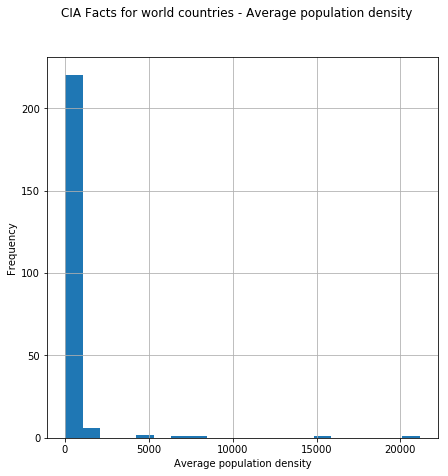

In [42]:
# Plot out an histogram of all remaining entries in the database
fig, axes = plt.subplots(figsize=(7,7))
fig.suptitle("CIA Facts for world countries - Average population density", fontsize=12)
pop_facts_not_null["pop_density"].hist(bins=20, ax=axes)
axes.set_xlabel("Average population density")
axes.set_ylabel("Frequency")

Finally, we can pull a new column from the database directly. Let's say we want to find out the water to land ratio for each of the countries in the database.

In [43]:
# We pull the new data directly from the database
query9 = '''
SELECT 
    name, 
    CAST(area_water AS FLOAT)/CAST(area_land AS FLOAT) AS water_land_ratio 
FROM facts 
ORDER BY water_land_ratio DESC;
'''
top_water_land_ratio = pd.read_sql_query(query9,conn)
top_water_land_ratio

,name,water_land_ratio
0,British Indian Ocean Territory,905.666667
1,Virgin Islands,4.520231
2,Puerto Rico,0.554791
3,"Bahamas, The",0.386613
4,Guinea-Bissau,0.284673
5,Malawi,0.259396
6,Netherlands,0.225710
7,Uganda,0.222922
8,Eritrea,0.164356
9,Liberia,0.156240


Once we're done with our work on the database the last step is simply to close the connection object we had opened at the beginning!

In [44]:
conn.close()